In [1]:
#importing necessary modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
import datetime
import math
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import matplotlib.pyplot as plt
import datetime
from torch import Tensor
from torch.nn import Linear
# random.seed(10)

/efs/litmus-server/users/yguptgau/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# TODO: node normalization, may not be needed
class GCNConvPy(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GCNConvPy, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # initializing weights
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        D = 1 / (1 + adj.sum(axis=1).unsqueeze(-1))   # inverse degree
        support = torch.mm(input, self.weight)
        output = D * torch.spmm(adj, support)     # following the formula for Graph Convolution
        if self.bias is not None:
            return output + self.bias           # adding bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'
    
# TODO/ASK: too many parameters
class NetPy(torch.nn.Module):
    def __init__(self):
        super(NetPy, self).__init__()
        self.conv1Mean = GCNConvPy(2,4)
        self.conv2Mean = GCNConvPy(4,4)
        self.lrelu = nn.LeakyReLU(0.1)
        self.lin1 = nn.Linear(4, 1)

    def forward(self, data, adj):
        # concatenating aqi and mask along dimension 1
        x, adj = torch.cat((data[:, 0].view(-1, 1), data[:, 1].view(-1,1)),1), adj
#         x, adj = torch.tensor(data[:, 0].view(-1, 1)), adj
        x = self.lrelu(self.conv1Mean(x, adj))
        x = self.lrelu(self.conv2Mean(x, adj))
        # passing through linear layer
        x = self.lin1(x)
        # prediction at each grid
        return torch.squeeze(x)

In [3]:
def prepare_data(datafile, hr_start, hr_end):
    #Put the file location
    df = pd.read_csv(datafile)

    #type casting
    df.pm1_0 = df.pm1_0.astype(float)
    df.pm2_5 = df.pm2_5.astype(float)
    df.pm10 = df.pm10.astype(float)
    df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
    df.long= round(round(5*df.long.astype(float),2)/5.0,3)

    # Ensuring Delhi region and removing outliers from data
    df = df[(df.lat.astype(int) == 28) &(df.long.astype(int) == 77)]
    df = df[(df.pm1_0<=1500) & (df.pm2_5<=1500) & (df.pm10<=1500) & (df.pm1_0>=20) & (df.pm2_5>=30) & (df.pm10>=30)]
    #df = df[(df.humidity<=60)&(df.humidity>=7)]
    df['lat_grid'] = df.apply(lambda row: int((n_lat_grid-1)*(row.lat-lat_range['min'])/(lat_range['max']-lat_range['min'])), axis=1 )
    df['long_grid'] = df.apply(lambda row: int((n_long_grid-1)*(row.long-long_range['min'])/(long_range['max']-long_range['min'])), axis=1 )
    df['lat_grid'] = df['lat_grid'].astype(float).astype(int)
    df['long_grid'] = df['long_grid'].astype(float).astype(int)


    #     # rounding @120min
    df.dateTime = pd.to_datetime(df.dateTime)
    df = df[df.dateTime.dt.hour>=hr_start]
    df = df[df.dateTime.dt.hour<hr_end]
    # df.dateTime = df.dateTime.dt.round('120min')
    # df.dateTime = df.dateTime.dt.hour*60 + df.dateTime.dt.minute

    df = df[["lat_grid", "long_grid", "pm2_5"]]
    df = df.groupby(['lat_grid', 'long_grid']).mean().reset_index()
    df = df.pivot_table(index=['lat_grid', 'long_grid'])

    return df


In [4]:
def train_test_split(df, grid_points_indices, train_size):
    #train-data for range from total grid structure
#     train_size = 0.8
    train_data = df.sample(frac = train_size, random_state = 0)
    test_data = df.drop(train_data.index)

    train_data["mask"] = 1
    train_data = train_data.reindex(grid_points_indices,fill_value=0)
    train_data = torch.tensor(train_data.values).float()
#     train_data_pm = train_data[:, 0]
#     train_data_mask = train_data[:, 1]

    test_data["mask"] = 1
    test_data = test_data.reindex(grid_points_indices,fill_value=0)
    test_data = torch.tensor(test_data.values).float()
#     test_data_pm = test_data[:, 0]
#     test_data_mask = test_data[:, 1]
    return train_data, test_data

def train(model, train_data, test_data, adj, opt):
    # training mode
    model.train()
    opt.zero_grad()
    # get the prediction of pm1.0
    output = model(train_data, adj)
    # calculating loss on predictions over know values.
    train_data_pm = train_data[:, 0]
    train_data_mask = train_data[:, 1]
    test_data_pm = test_data[:, 0]
    test_data_mask = test_data[:, 1]
    
    train_loss = F.mse_loss(output[train_data_pm>0] ,train_data_pm[train_data_pm>0])
    test_loss = F.mse_loss(output[test_data_pm>0] ,test_data_pm[test_data_pm>0])
#     train_loss = F.mse_loss(torch.reshape(output,(-1,)) * train_data_mask, torch.reshape(train_data_pm,(-1,)))
#     test_loss = F.mse_loss(torch.reshape(output,(-1,)) * test_data_mask, torch.reshape(test_data_pm,(-1,)))
    train_loss.backward()
    opt.step()
    train_rmse = torch.sqrt(train_loss)
    test_rmse = torch.sqrt(test_loss)
    return train_loss, train_rmse, test_loss, test_rmse

def eval_model(model, train_data, test_data):
    model.eval()
    output = model(train_data, adj)
    test_data_mask = test_data[:, 1]
    test_output = (torch.reshape(output,(-1,)) * test_data_mask)
    true_test_output = test_data[:, 0]
    test_loss = F.mse_loss(test_output[true_test_output>0], true_test_output[true_test_output>0])
    
    rmse_test_loss = torch.sqrt(test_loss)
    return test_output, test_loss.item(), rmse_test_loss.item()

In [15]:
import matplotlib.pyplot as plt
def plot_train_test(train_loss_array, test_loss_array):
    fig = plt.figure(figsize=(6, 4))
    titleFontSize = 15
    labelFontSize = 12
    tickFontSize = 10
    legendFontSize = 10
    labelStr = "size = "
    yLabel = "% of test points with lower error"
    xLabel = "Error %"
    count_arr = [i for i in range(1, len(train_loss_array) + 1)]
    plt.plot(count_arr, train_loss_array, label = "Train loss", color='red')
    plt.plot(count_arr, test_loss_array, label = "Test loss", color='blue')
    plt.title("Training loss vs epochs(Pytorch)", fontsize=titleFontSize)
    plt.xlabel("Epochs", fontsize=labelFontSize)
    plt.ylabel("Training loss", fontsize=labelFontSize)
    plt.xticks(fontsize=tickFontSize)
    plt.yticks(fontsize=tickFontSize)
    plt.tight_layout()
    plt.legend(prop={"size": legendFontSize})
    # plt.savefig("pytorch_loss.png")
    return fig

def plot_prediction(model, train_data, test_data):
    #all test result visualization
    test_output, _,_ = eval_model(model, train_data, test_data)
    test_output = test_output.detach().numpy()
    fig = plt.figure(figsize=(9, 5))
    test_true = test_data[:, 0]
    a_pred = test_output[test_output>0]
    a_true = test_true[test_true>0]
    plt.plot(a_pred, "r-", label="prediction")
    plt.plot(a_true, "b-", label="true")
    plt.xlabel("grid point")
    plt.ylabel("PM2.5")
    plt.legend(loc="best", fontsize=10)
    plt.show()
    return fig

In [16]:
from time import time
def interpolate(day, hr_start, hr_end, n_epochs, train_size, grid_points_indices):
    model = NetPy()
    optimizer = "SGD"
    if (optimizer == "SGD"):
    #     opt = torch.optim.SGD(model.parameters(), lr=0.0001, weight_decay=0.01, momentum = 0.1, nesterov=True)
        opt = torch.optim.SGD(model.parameters(), lr = 3*1e-5) 
    else:
        opt = torch.optim.Adam(model.parameters(), lr = 0.01)  
        
    df = prepare_data('PM Datasets/' + day + '_all.csv', hr_start, hr_end)
    train_data, test_data = train_test_split(df, grid_points_indices, train_size = 0.8)    
    
    train_loss_array = []
    train_rmse_array = []
    test_loss_array = []
    test_rmse_array = []
    t0 = time()

    for i in range(n_epochs):
        train_loss, train_rmse, test_loss, test_rmse = train(model, train_data, test_data, adj, opt)
        train_loss_array.append(train_loss.detach().numpy())
        train_rmse_array.append(float(train_rmse.detach().numpy()))
        test_loss_array.append(test_loss.detach().numpy())
        test_rmse_array.append(float(test_rmse.detach().numpy()))
    #     print(f"{str(i)}: Train RMSE:{rmse_loss[0]}, Validation RMSE:{rmse_loss[1]}")

    traintime = time() - t0
    print("Training Time: "+str(traintime))
    print("Mean Train RMSE: "+str(np.mean(train_rmse_array)))
    print("Last Train RMSE: "+str(train_rmse_array[-1]))
    print("Mean Test RMSE: "+str(np.mean(test_rmse_array)))
    print("Last Test RMSE : "+str(test_rmse_array[-1]))
    
    fig1 = plot_train_test(train_loss_array, test_loss_array) 
    fig = plot_prediction(model, train_data, test_data)
    return 

In [17]:
from scipy.spatial.distance import pdist, squareform
random.seed(10)
torch.manual_seed(42)

lat_range = {'min': 28.486, 'max': 28.72}
long_range = {'min': 77.1, 'max': 77.32}
n_lat_grid = 25
n_long_grid = 25

#adjacency matrix
grid_points = pd.read_csv('grid_points_25.csv')
n_grid_points = grid_points.shape[0] 
X = grid_points[["lat_grid", "long_grid"]].to_numpy()
f = lambda u, v: max(abs(u-v))<=1
adj = squareform(pdist(X, f))
eye = np.identity(n_grid_points)
adj = adj+eye
adj = torch.tensor(adj).float()
print(adj.shape) 

grid_points = grid_points.pivot_table(index=['lat_grid', 'long_grid'])
grid_points_indices = grid_points.index

torch.Size([270, 270])


In [18]:
# prepare_data('PM Datasets/2020-12-07_all.csv', hr_start = 17, hr_end = 19)

Training Time: 0.04903697967529297
Mean Train RMSE: 43.375783157348636
Last Train RMSE: 22.344839096069336
Mean Test RMSE: 45.25045318603516
Last Test RMSE : 27.690597534179688


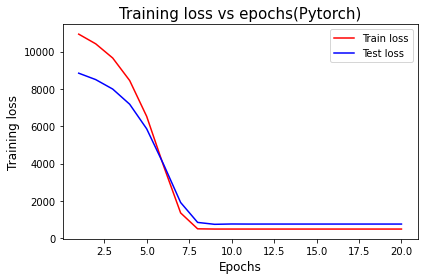

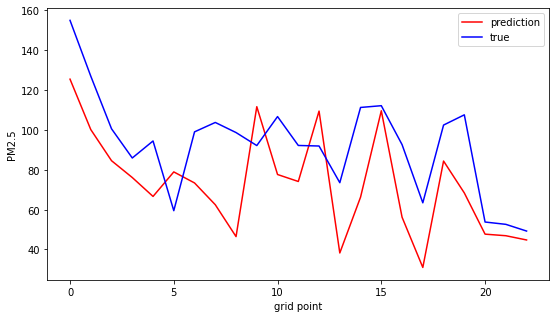

In [19]:
interpolate(day = '2021-01-30', hr_start = 16, hr_end = 19, n_epochs = 20, train_size = 0.8, grid_points_indices = grid_points_indices)


In [30]:
# results = pd.DataFrame()
# results[day] = [traintime, np.mean(train_rmse_array), train_rmse_array[-1], np.mean(test_rmse_array), test_rmse_array[-1]]
# index = pd.Index(['Training Time', 'Mean Train RMSE', 'Last Train RMSE', 'Mean Test RMSE', 'Last Test RMSE'])
# results = results.set_index(index)
# # results = pd.read_csv('results_GCN.csv', index_col=0)
# # results[day] = [traintime, np.mean(train_rmse_array), train_rmse_array[-1], np.mean(test_rmse_array), test_rmse_array[-1]]
# results.to_csv('results_GCN.csv')

In [ ]:
# results

In [ ]:
# from time import time
# random.seed(10)
# torch.manual_seed(42)
# model = NetPy()
# optimizer = "SGD"
# if (optimizer == "SGD"):
# #     opt = torch.optim.SGD(model.parameters(), lr=0.0001, weight_decay=0.01, momentum = 0.1, nesterov=True)
#     opt = torch.optim.SGD(model.parameters(), lr = 1e-5) 
# else:
#     opt = torch.optim.Adam(model.parameters(), lr = 0.01)    

# import matplotlib.pyplot as plt
# titleFontSize = 15
# labelFontSize = 12
# tickFontSize = 10
# legendFontSize = 10 
# results = pd.DataFrame()

# for i in range(1, 31):
#     if i<10:
#         datafile = 'PM Datasets/2020-12-' + str(0) + str(i) + '_all.csv'
#     else:
#         datafile = 'PM Datasets/2020-12-' + str(i) + '_all.csv'
    
#     df = prepare_data(datafile)
#     train_data, test_data = train_test_split(df, grid_points_indices, train_size = 0.8)
#     l, train_loss_array, test_loss_array = interpolate(model, train_data, test_data, 50)

#     titleFontSize = 15
#     labelFontSize = 12
#     tickFontSize = 10
#     legendFontSize = 10
#     labelStr = "size = "
#     yLabel = "% of test points with lower error"
#     xLabel = "Error %"
#     count_arr = [i for i in range(1, len(train_loss_array) + 1)]
#     plt.plot(count_arr, train_loss_array, label = "Train loss", color='red')
#     plt.plot(count_arr, test_loss_array, label = "Test loss", color='blue')
#     plt.title("Training loss vs epochs(Pytorch)", fontsize=titleFontSize)
#     plt.xlabel("Epochs", fontsize=labelFontSize)
#     plt.ylabel("Training loss", fontsize=labelFontSize)
#     plt.xticks(fontsize=tickFontSize)
#     plt.yticks(fontsize=tickFontSize)
#     plt.tight_layout()
#     plt.legend(prop={"size": legendFontSize})

#     test_output, _,_ = eval(model, train_data, test_data)
#     test_output = test_output.detach().numpy()
#     fig1 = plt.figure(figsize=(6, 6))
#     test_true = test_data[:, 0]
#     a_pred = test_output[test_output>0]
#     a_true = test_true[test_true>0]
#     plt.plot(a_pred, "r-", label="prediction")
#     plt.plot(a_true, "b-", label="true")
#     plt.xlabel("grid point")
#     plt.ylabel("PM2.5")
#     plt.legend(loc="best", fontsize=10)
#     plt.show()